In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # default = 'warn'
pd.set_option('display.max_columns', 500)

In [2]:
#training data

train_df = pd.read_csv('train.csv', parse_dates = ['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates = ['timestamp'])

train_df['price_doc_log'] = np.log1p(train_df['price_doc']) # creates new col of log price

In [3]:
# merge macro and train_df

train = pd.merge_ordered(train_df, macro, on='timestamp', how='left')

In [4]:
# missing data

train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending = False)

[<matplotlib.text.Text at 0x4217a320>, <matplotlib.text.Text at 0x4b296e80>]

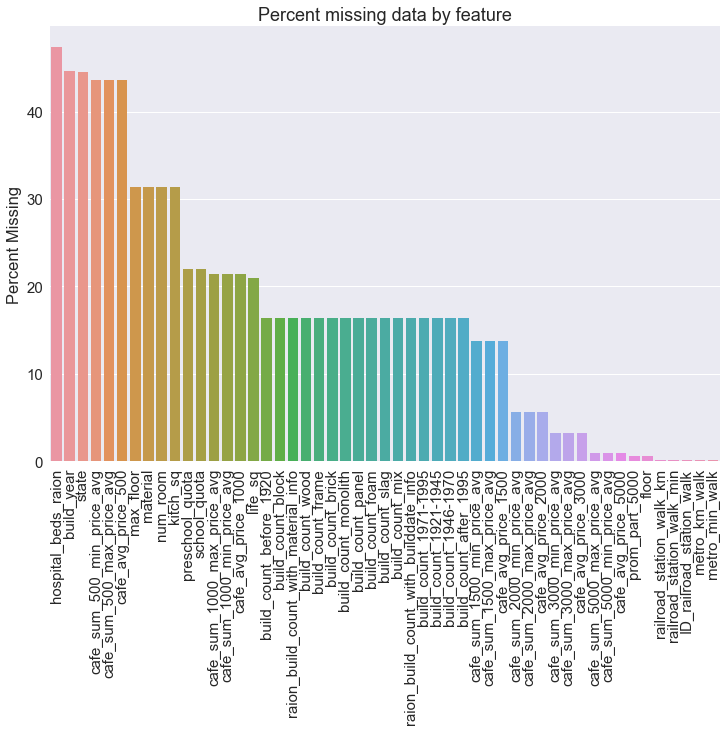

In [91]:
f, ax = plt.subplots(figsize = (12,8))  # no idea what this does
sns.set(font_scale = 1.5)
plt.xticks(rotation = '90')
sns.barplot(x=train_na.index, y = train_na)
ax.set(title='Percent missing data by feature', ylabel = 'Percent Missing') #ax, wheres f

In [6]:
# data quality issues

In [7]:
#state should be between 3 and 4
train_df.loc[train_df['state'] == 33, 'state'] = 3

In [8]:
# buildyear has 20052009, so ill replace it with finishing year 2009
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2009

In [9]:
# housing internal characteristics

In [10]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 
                  'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df[internal_chars].corr()

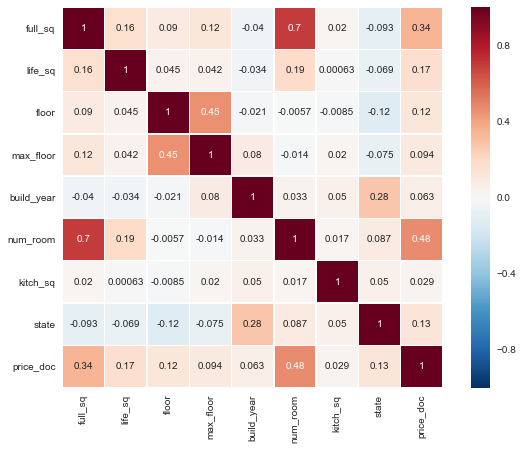

In [11]:
f, ax = plt.subplots(figsize = (10,7))
plt.xticks(rotation = '90')
sns.heatmap(corrmat, square = True, linewidths = 0.5, annot = True)

# high corr between full_Sq and num_rm
# somewhat max_floor and floor
# somewhat state and build_year
# num_room then full_sq most correlated with price

In [12]:
# area of home and number of rooms

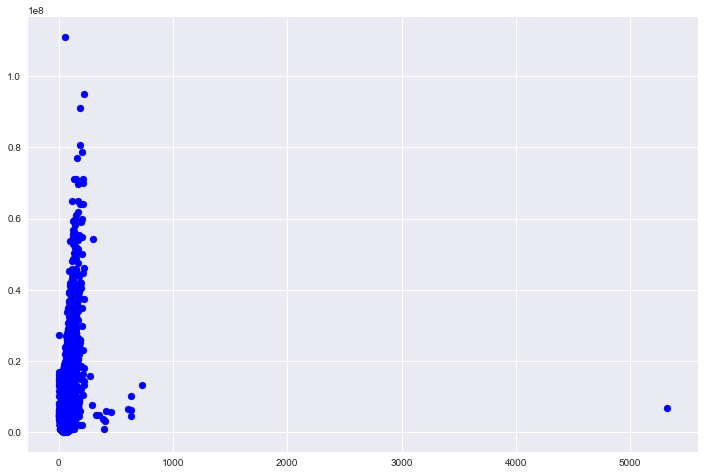

In [13]:
f, ax = plt.subplots(figsize = (12,8))
plt.scatter(x = train_df['full_sq'], y = train_df['price_doc'], c = 'b') 
# what is this c = r business??? # means color = 'red'

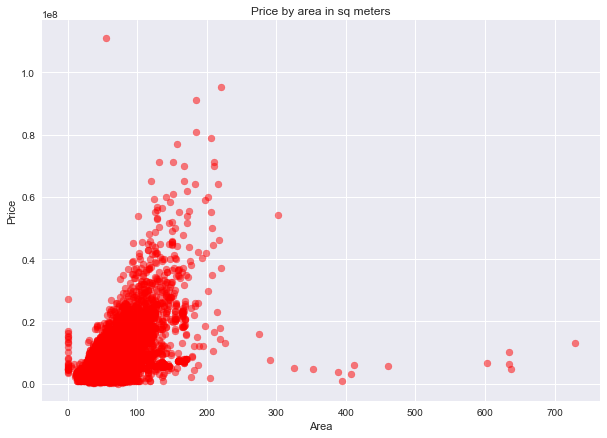

In [14]:
f, ax = plt.subplots(figsize = (10,7))
ind = train_df[train_df['full_sq']> 2000].index #get index of outlier
plt.scatter(x = train_df.drop(ind)['full_sq'], y = train_df.drop(ind)['price_doc'], c = 'r', alpha = 0.5)
ax.set(title = 'Price by area in sq meters', xlabel = 'Area', ylabel = 'Price')

In [15]:
# how many life_sq are bigger than full_sq??
(train_df['life_sq'] > train_df['full_sq']).sum()

37

[<matplotlib.text.Text at 0x128afbe0>, <matplotlib.text.Text at 0x1110a048>]

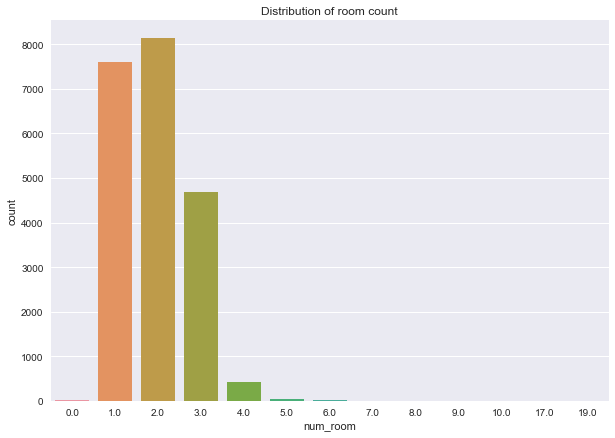

In [16]:
f, ax = plt.subplots(figsize = (10,7))
sns.countplot(x = train_df['num_room'])
ax.set(title = 'Distribution of room count', xlabel = 'num_room')

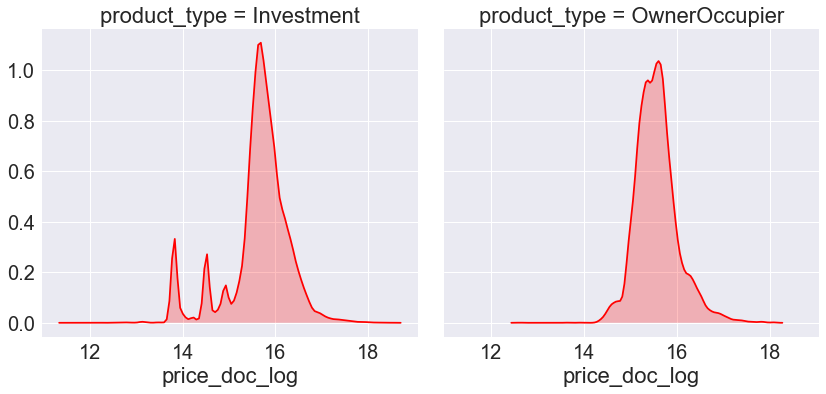

In [119]:
g = sns.FacetGrid(train_df, col = 'product_type', size = 6) # inestment vs. owner, half of  page
sns.set(font_scale = 2)
g.map(sns.kdeplot, 'price_doc_log', color = 'r', shade = True)
# g.add_legend()
ax.set(ylabel = 'density')
#spikes in random places in investment

In [18]:
train_df.groupby('product_type')['price_doc'].median()
# surprisingly base don the graphs, the median price for investment properties is higher

product_type
Investment       6670000
OwnerOccupier    5564090
Name: price_doc, dtype: int64

In [19]:
# build year

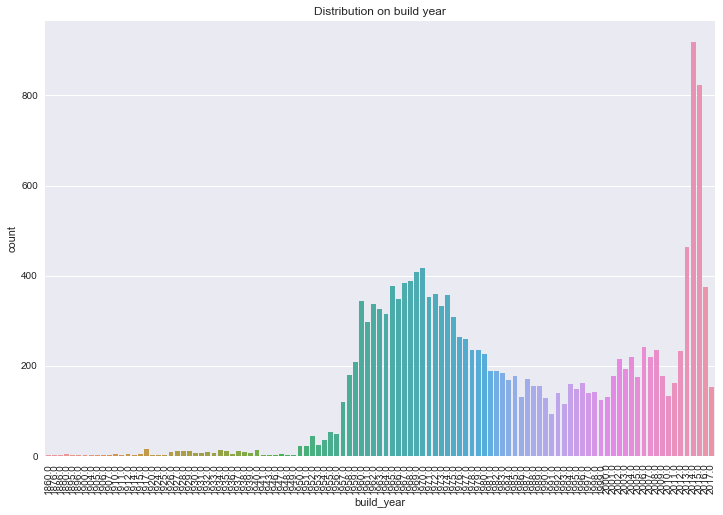

In [20]:
f, ax = plt.subplots(figsize = (12,8))
plt.xticks(rotation = '90')
ind = train_df[(train_df['build_year'] <= 1691) | 
               (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(ind).sort_values(by = ['build_year']) # by_df = build_year
sns.countplot(x = by_df['build_year'])
ax.set(title = 'Distribution on build year')


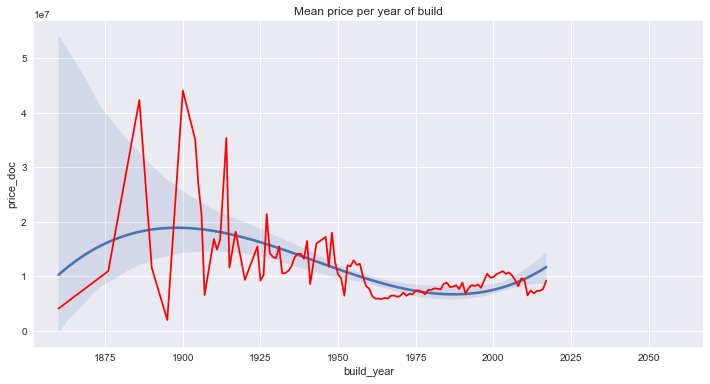

In [21]:
f, ax = plt.subplots(figsize = (12,6))
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
sns.regplot(x = 'build_year', 
            y = 'price_doc', 
            data = by_price, 
            scatter = False, 
            order = 3,
            truncate = True)
plt.plot(by_price['build_year'], by_price['price_doc'], color = 'r')
ax.set(title = 'Mean price per year of build')

# time stamp

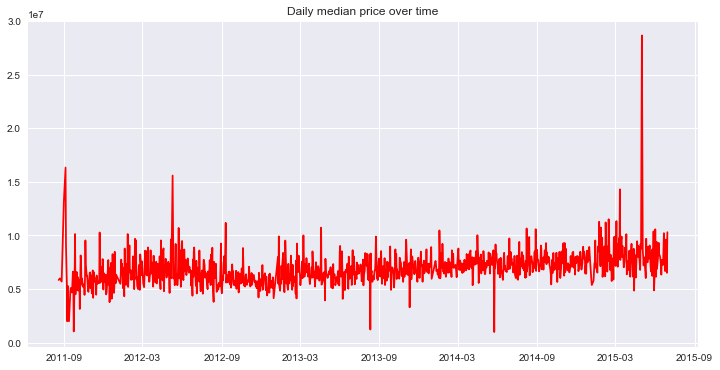

In [22]:
f, ax = plt.subplots(figsize=(12,6))
ts_df = train_df.groupby('timestamp')[['price_doc']].mean()
plt.plot(ts_df.index, ts_df['price_doc'], color = 'r')
ax.set(title = 'Daily median price over time')

[<matplotlib.text.Text at 0x261b3908>, <matplotlib.text.Text at 0x26beb710>]

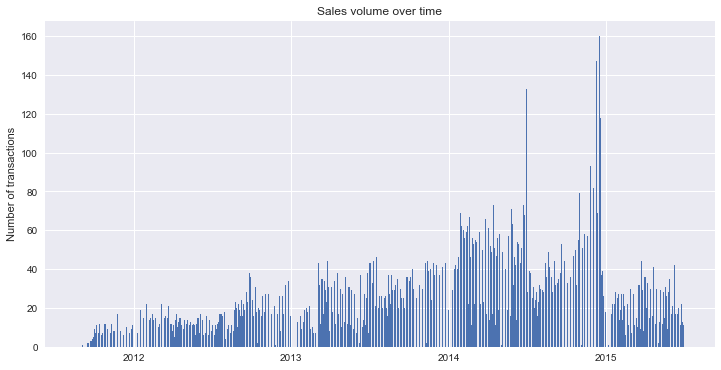

In [23]:
import datetime
import matplotlib.dates as mdates
years = mdates.YearLocator() # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc = train_df['timestamp'].value_counts() #timestamp value counts

f, ax = plt.subplots(figsize=(12,6))
plt.bar(left = ts_vc.index, height = ts_vc)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Sales volume over time', ylabel='Number of transactions')

# home state material

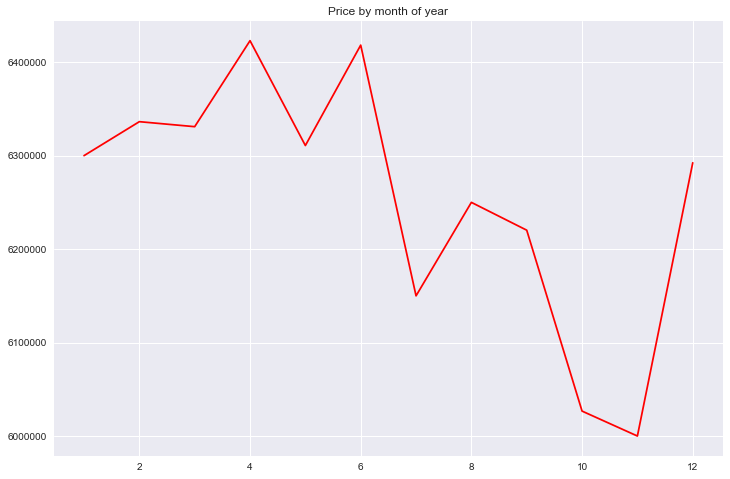

In [24]:
f, ax = plt.subplots(figsize=(12, 8))
ts_df = train_df.groupby(by=[train_df.timestamp.dt.month])[['price_doc']].median()
plt.plot(ts_df.index, ts_df, color='r')
ax.set(title='Price by month of year')

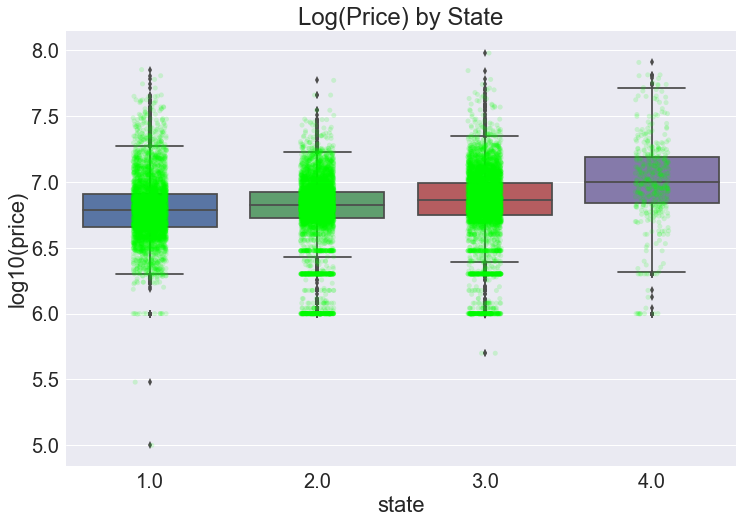

In [118]:
f, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale = 2)
ind = train_df[train_df['state'].isnull()].index
train_df['price_doc_log'] = np.log(train_df['price_doc'])
# sns.violinplot(x="state", y="price_doc_log10", 
#                data=train_df.drop(ind), inner="box")
sns.stripplot(x="state", y="price_doc_log10", 
              data=train_df.drop(ind),
             jitter = True,
             alpha = 0.15,
             color = 'lime')
sns.boxplot(x="state", y="price_doc_log10", 
               data=train_df.drop(ind))




ax.set(title='Log(Price) by State', 
       xlabel='state', ylabel='log10(price)')

# 4 is the most expensive but the other three look pretty evenly distributed


# f, ax = plt.subplots(figsize=(12, 8))
# sns.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
# sns.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
# ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
#        ylabel='price_doc'

In [26]:
train_df.drop(ind).groupby('state')['price_doc'].mean()

state
1.0    7.315440e+06
2.0    7.060064e+06
3.0    8.078475e+06
4.0    1.334547e+07
Name: price_doc, dtype: float64

In [27]:
# what are the six materials again???  is the most expensive

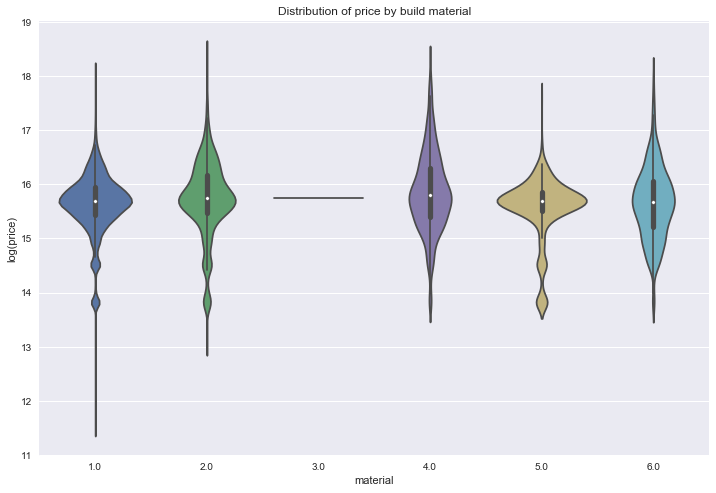

In [28]:
f, ax = plt.subplots(figsize=(12, 8))     #always dropping is null first
ind = train_df[train_df['material'].isnull()].index
sns.violinplot(x="material", y="price_doc_log", 
               data=train_df.drop(ind), 
               inner="box")

# sns.swarmplot(x="state", y="price_doc_log10",
#          data=train_df.dropna(), color="w", alpha=.2);

ax.set(title='Distribution of price by build material', 
       xlabel='material', ylabel='log(price)')

In [29]:
train_df.drop(ind).groupby('material')['price_doc'].median()

material
1.0    6500000.0
2.0    6900000.0
3.0    6931143.0
4.0    7247869.5
5.0    6492000.0
6.0    6362318.0
Name: price_doc, dtype: float64

# floor of home

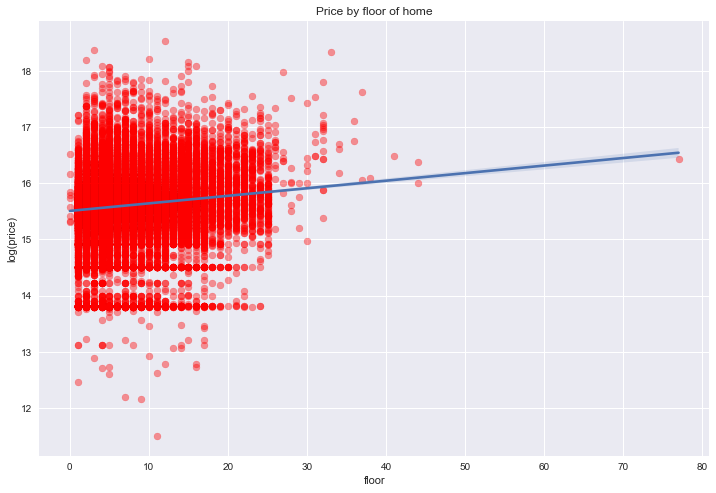

In [30]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by floor of home', xlabel='floor', ylabel='log(price)')

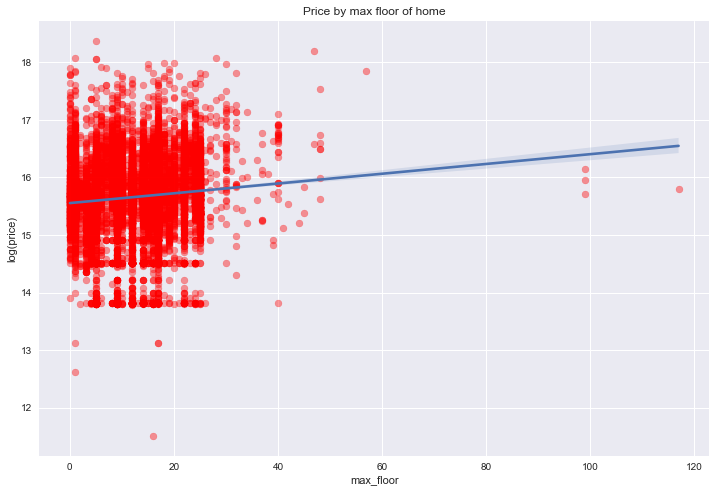

In [31]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['max_floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="max_floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by max floor of home', xlabel='max_floor', ylabel='log(price)')

973

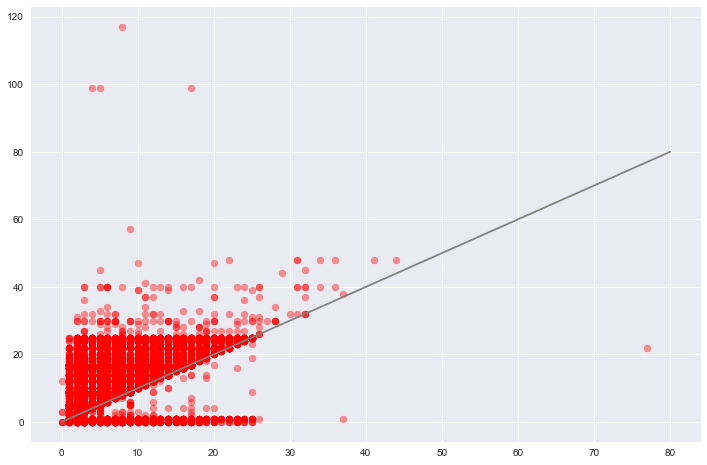

In [32]:
# floor v. maxfloor
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
plt.plot([0, 80], [0, 80], color='.5')
sum(train_df['max_floor'] == 1)

In [33]:
train_df.loc[train_df['max_floor'] < train_df['floor'], 
             ['id', 'floor','max_floor']].head(20)

id  floor  max_floor
8216  8219   13.0        0.0
8268  8271    3.0        1.0
8499  8502    2.0        0.0
8531  8534    7.0        0.0
8912  8915    5.0        0.0
9161  9164    8.0        3.0
9257  9260    8.0        1.0
9309  9312    5.0        1.0
9388  9391   10.0        1.0
9412  9415    4.0        1.0
9423  9426    8.0        0.0
9442  9445    9.0        1.0
9452  9455    8.0        1.0
9482  9485   12.0        1.0
9561  9564    7.0        1.0
9689  9692    2.0        1.0
9696  9699    2.0        1.0
9724  9727    7.0        1.0
9764  9767   24.0        1.0
9822  9825   14.0        1.0

# demo charactersis 

In [34]:
demo_vars = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 
             'work_all', 'work_male', 'work_female', 'price_doc']
corrmat = train_df[demo_vars].corr()   # correlation of demos

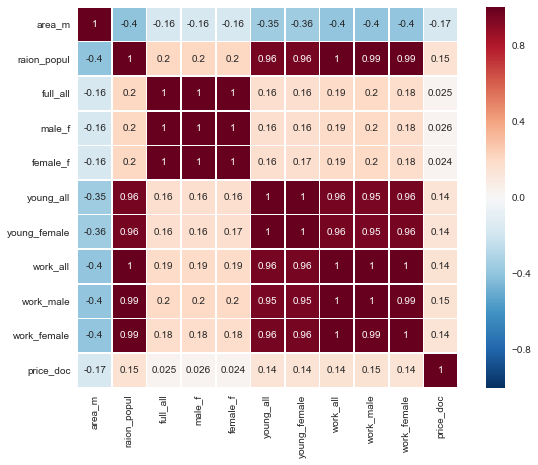

In [35]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [36]:
train_df['sub_area'].unique().shape[0]  # how many unique subareas (raions) are there?

146L

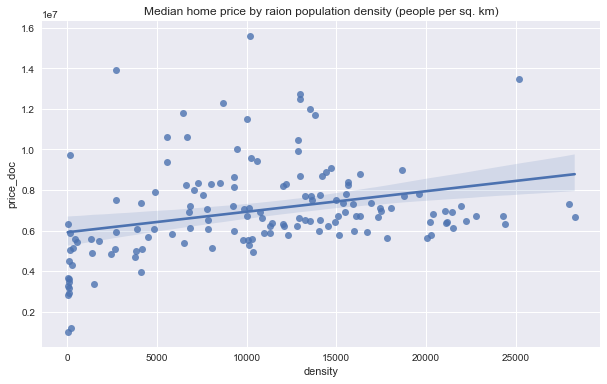

In [37]:
train_df['area_km'] = train_df['area_m'] / 1000000
train_df['density'] = train_df['raion_popul'] / train_df['area_km']
f, ax = plt.subplots(figsize=(10, 6))
sa_price = train_df.groupby('sub_area')[['density', 'price_doc']].median()
sns.regplot(x="density", y="price_doc", data=sa_price, scatter=True, truncate=True)
ax.set(title='Median home price by raion population density (people per sq. km)')

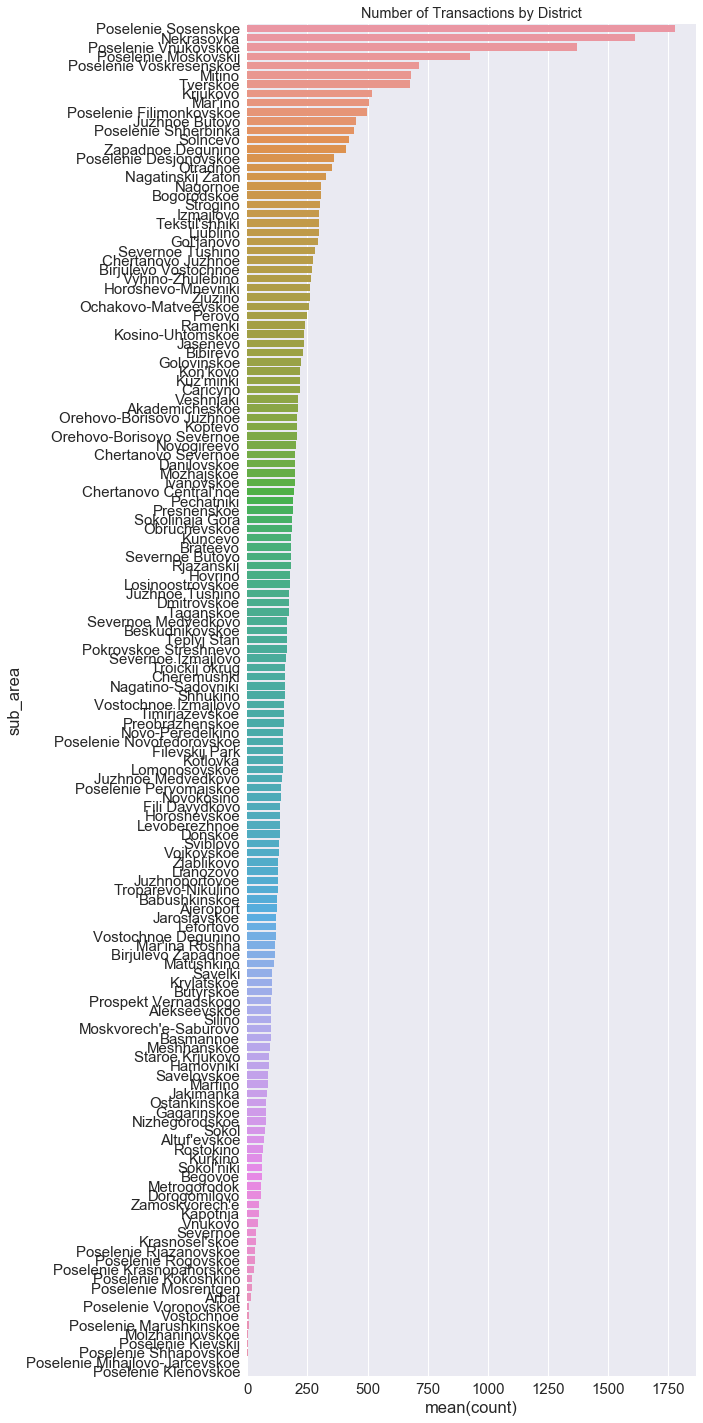

In [114]:
f, ax = plt.subplots(figsize=(10, 20))
sa_vc = train_df['sub_area'].value_counts()
sns.set(font_scale = 1.2)
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count': sa_vc.values})
ax = sns.barplot(x="count", y="sub_area", data=sa_vc, orient="h")
ax.set(title='Number of Transactions by District')
f.tight_layout()

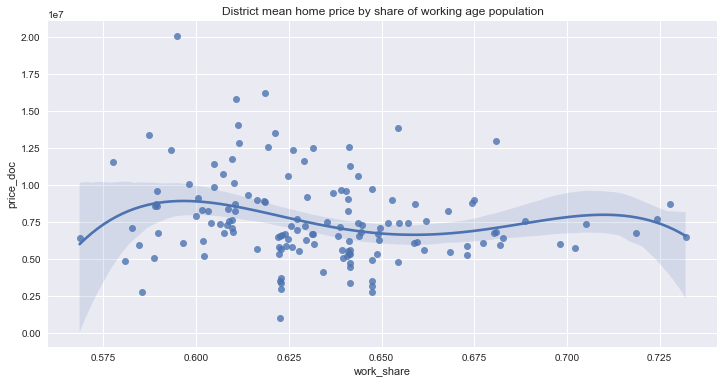

In [39]:
train_df['work_share'] = train_df['work_all'] / train_df['raion_popul']
f, ax = plt.subplots(figsize=(12, 6))
sa_price = train_df.groupby('sub_area')[['work_share', 'price_doc']].mean()
sns.regplot(x="work_share", y="price_doc", data=sa_price, scatter=True, order=4, truncate=True)
ax.set(title='District mean home price by share of working age population')

# schools

In [40]:
school_chars = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']
corrmat = train_df[school_chars].corr()

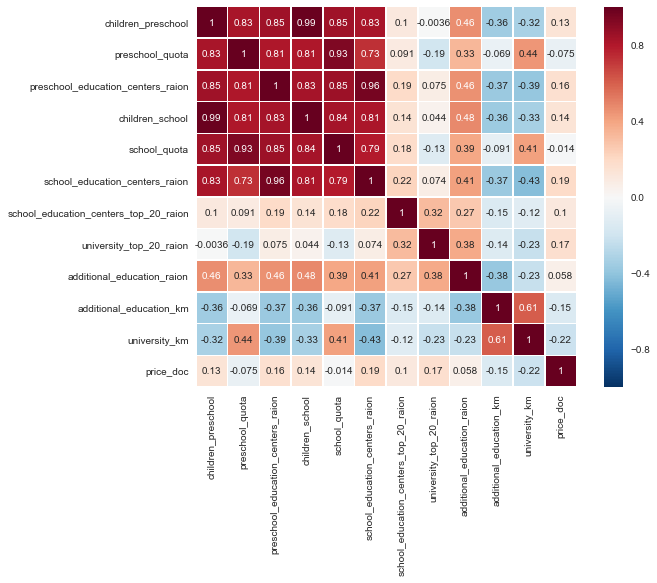

In [41]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [42]:
train_df['university_top_20_raion'].unique() # confused by this

array([0, 2, 1, 3], dtype=int64)

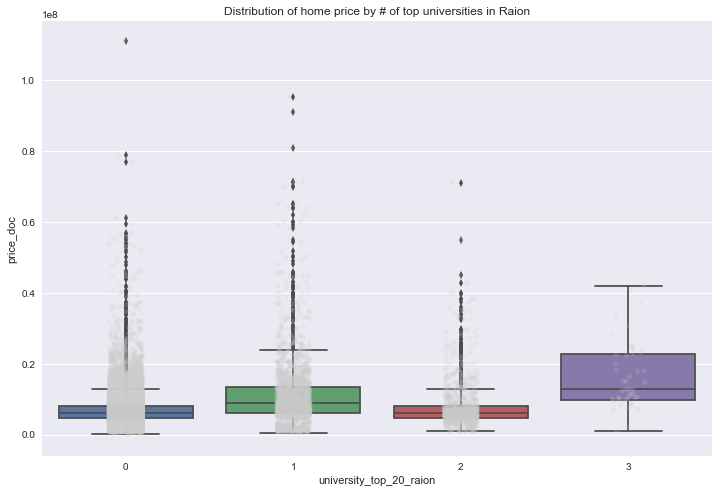

In [43]:
f, ax = plt.subplots(figsize=(12, 8))
sns.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
sns.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
       ylabel='price_doc')

# cult/rec characterisitics

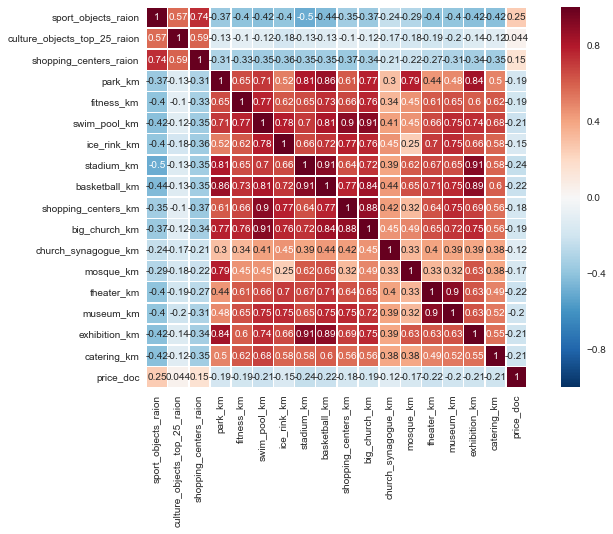

In [44]:
cult_chars = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
                'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km', 'shopping_centers_km', 'big_church_km',
                'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'price_doc']
corrmat = train_df[cult_chars].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

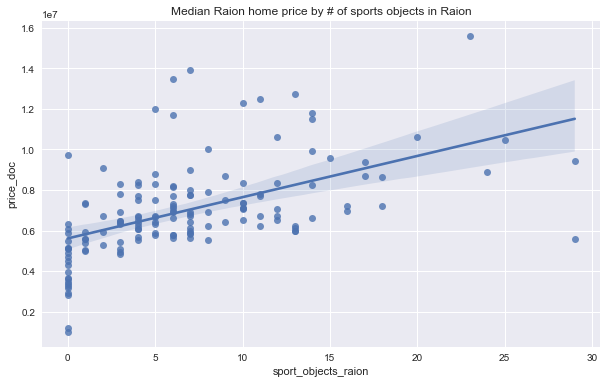

In [45]:
f, ax = plt.subplots(figsize=(10, 6))
so_price = train_df.groupby('sub_area')[['sport_objects_raion', 'price_doc']].median()
sns.regplot(x="sport_objects_raion", y="price_doc", data=so_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')


# more rec centers more money

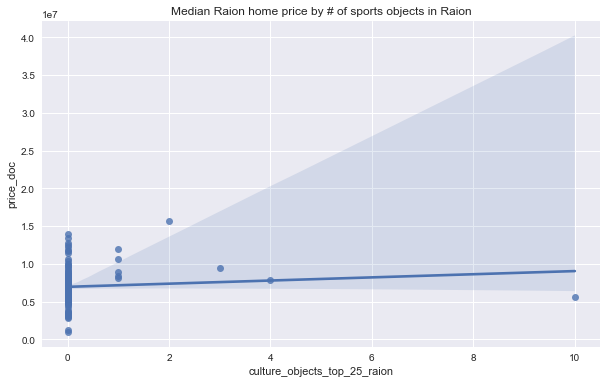

In [46]:
f, ax = plt.subplots(figsize=(10, 6))
co_price = train_df.groupby('sub_area')[['culture_objects_top_25_raion', 'price_doc']].median()
sns.regplot(x="culture_objects_top_25_raion", y="price_doc", data=co_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

# not helpful

In [47]:
train_df.groupby('culture_objects_top_25')['price_doc'].median()


# significant increase if culture objects are top 25

culture_objects_top_25
no     6200000
yes    7400000
Name: price_doc, dtype: int64

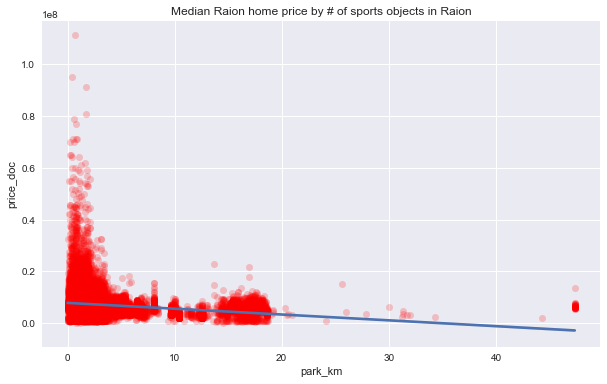

In [48]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="park_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Median Raion home price by # of sports objects in Raion')

# farther away = less expensive and most expensive are all less than 5 


# infrastructure features

In [49]:
inf_features = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km', 'incineration_km',
                'water_treatment_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 
                'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 
                'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km',
                'kremlin_km', 'price_doc']
corrmat = train_df[inf_features].corr()

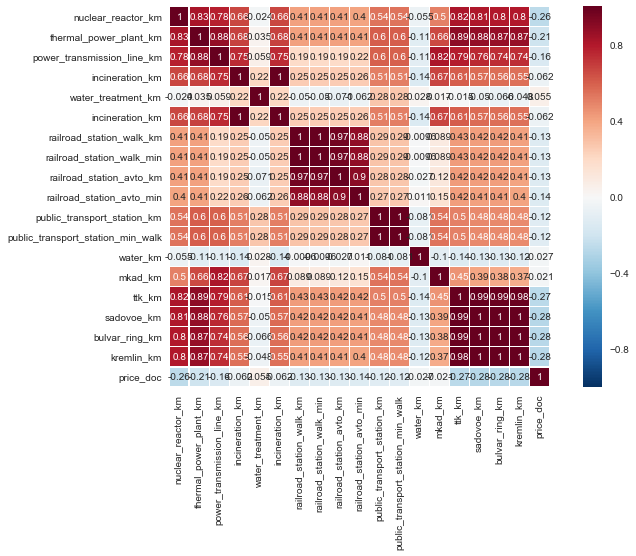

In [50]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)


# for some reason all negative with price and I dont understand why
# oh because higher km means further away which is bad! 
# people want to live in city center or next to kremlin!!!



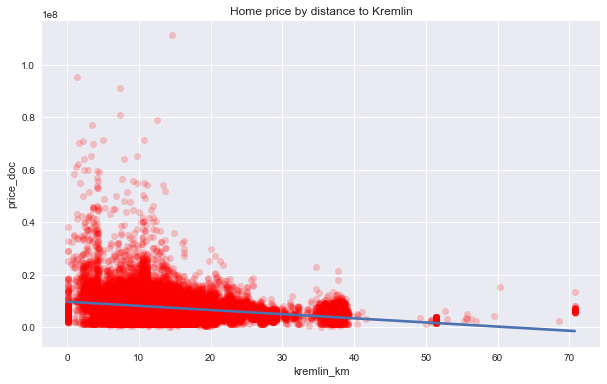

In [51]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="kremlin_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Home price by distance to Kremlin')

# variable importance

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train = train_df.drop(labels=['timestamp', 'id', 'incineration_raion'], axis=1).dropna()
y_train = X_train['price_doc']
X_train.drop('price_doc', axis=1, inplace=True)
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(X_train[f])
        X_train[f] = lbl.transform(X_train[f])
rf = RandomForestRegressor(random_state=0)
rf = rf.fit(X_train, y_train)

In [53]:
# train_df.columns.values

In [54]:
fi = list(zip(X_train.columns, rf.feature_importances_))
print('## rf variable importance')
for i in fi[:20]:
    print('## %-40s%s' % (i)) 
    
    
    
    # not really sure what this means??????????????

## rf variable importance
## full_sq                                 5.87095874357e-07
## life_sq                                 9.04347628546e-08
## floor                                   1.20590421994e-08
## max_floor                               1.20794309636e-07
## material                                7.64088471084e-08
## build_year                              5.56703735125e-05
## num_room                                1.18520322785e-06
## kitch_sq                                5.87408823398e-08
## state                                   1.4491456575e-07
## product_type                            2.21240486991e-08
## sub_area                                5.77751434754e-09
## area_m                                  6.22619361625e-07
## raion_popul                             2.39214582143e-08
## green_zone_part                         2.57185801048e-07
## indust_part                             5.86329500469e-08
## children_preschool                      4.39636702546e-08

# train vs test data

In [55]:
test_df = pd.read_csv("test.csv", parse_dates=['timestamp'])
test_na = (test_df.isnull().sum() / len(test_df)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)

[<matplotlib.text.Text at 0x29e66b38>, <matplotlib.text.Text at 0x2a885cf8>]

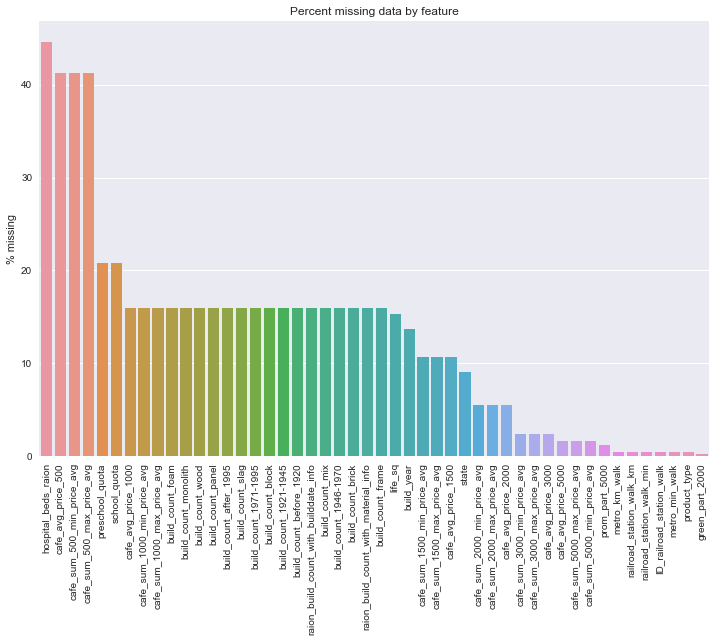

In [56]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=test_na.index, y=test_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [57]:
all_data = pd.concat([train_df.drop('price_doc', axis=1), test_df])
all_data['dataset'] = ''
l = len(train_df)
all_data.iloc[:l]['dataset'] = 'train'
all_data.iloc[l:]['dataset'] = 'test'
train_dataset = all_data['dataset'] == 'train'

[<matplotlib.text.Text at 0x2a9c8160>, <matplotlib.text.Text at 0x2261bd68>]

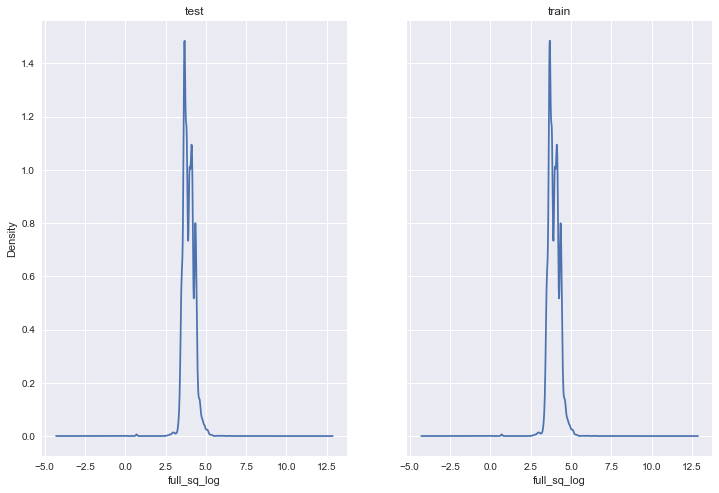

In [58]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['full_sq_log'] = np.log1p(all_data['full_sq'])
all_data.drop(train_dataset)["full_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["full_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='full_sq_log')
ax[1].set(title='train', xlabel='full_sq_log')

# look similar for full sq comparisons

[<matplotlib.text.Text at 0x2a93d198>, <matplotlib.text.Text at 0x2a957e80>]

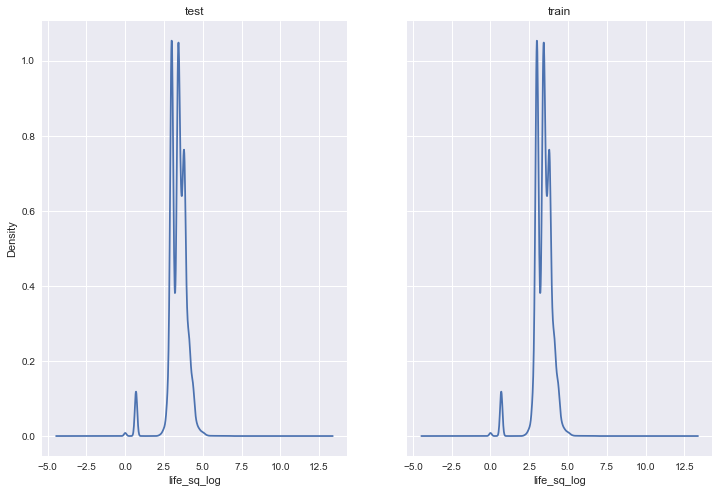

In [59]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['life_sq_log'] = np.log1p(all_data['life_sq'])
all_data.drop(train_dataset)["life_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["life_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='life_sq_log')
ax[1].set(title='train', xlabel='life_sq_log')

[<matplotlib.text.Text at 0x36935e10>, <matplotlib.text.Text at 0x36539f98>]

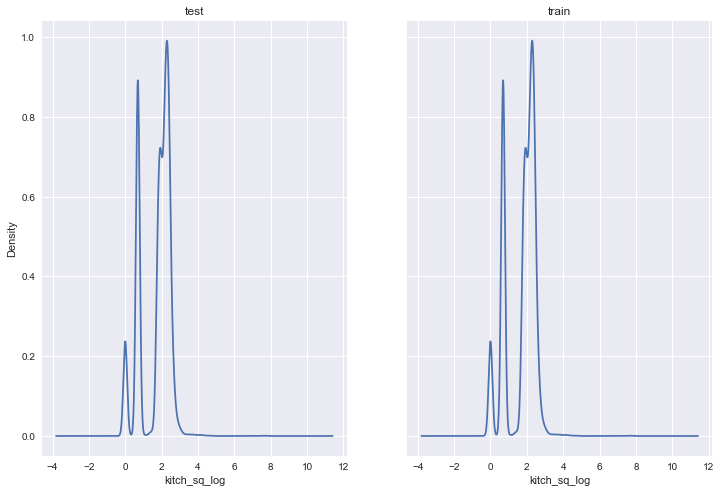

In [60]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['kitch_sq_log'] = np.log1p(all_data['kitch_sq'])
all_data.drop(train_dataset)["kitch_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["kitch_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='kitch_sq_log')
ax[1].set(title='train', xlabel='kitch_sq_log')

[<matplotlib.text.Text at 0x36774630>, <matplotlib.text.Text at 0x36793080>]

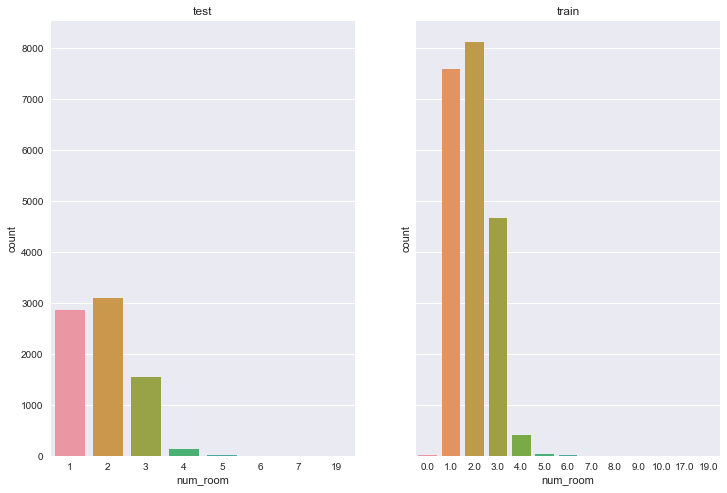

In [61]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['num_room'], ax=ax[0])
sns.countplot(x=train_df['num_room'], ax=ax[1])
ax[0].set(title='test', xlabel='num_room')
ax[1].set(title='train', xlabel='num_room')

[<matplotlib.text.Text at 0x2a34f438>, <matplotlib.text.Text at 0x2a366be0>]

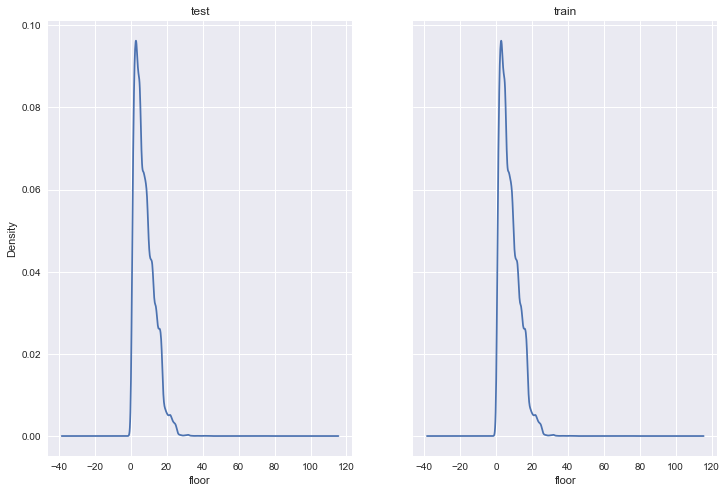

In [62]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data.drop(train_dataset)["floor"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["floor"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='floor')
ax[1].set(title='train', xlabel='floor')

[<matplotlib.text.Text at 0x2b398e80>, <matplotlib.text.Text at 0x2b3c9160>]

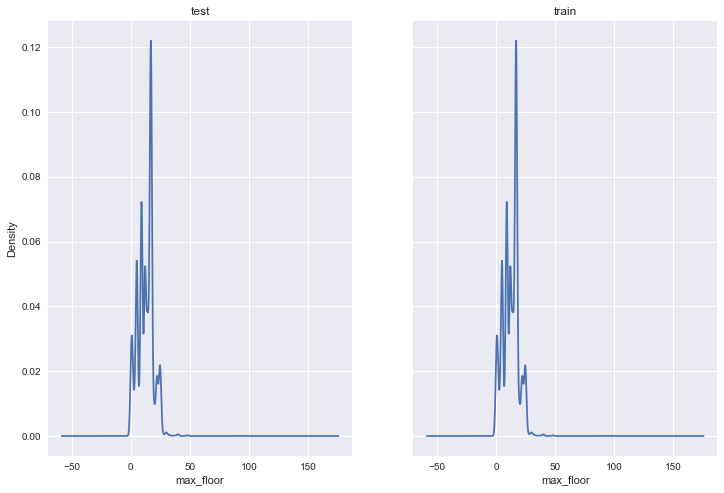

In [63]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data.drop(train_dataset)["max_floor"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["max_floor"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='max_floor')
ax[1].set(title='train', xlabel='max_floor')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
ax[0].scatter(x=test_df['floor'], y=test_df['max_floor'], c='r', alpha=0.4)
ax[0].plot([0, 80], [0, 80], color='.5')
ax[1].scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
ax[1].plot([0, 80], [0, 80], color='.5')
ax[0].set(title='test', xlabel='floor', ylabel='max_floor')
ax[1].set(title='train', xlabel='floor', ylabel='max_floor')

[<matplotlib.text.Text at 0x43f63cc0>, <matplotlib.text.Text at 0x43915fd0>]

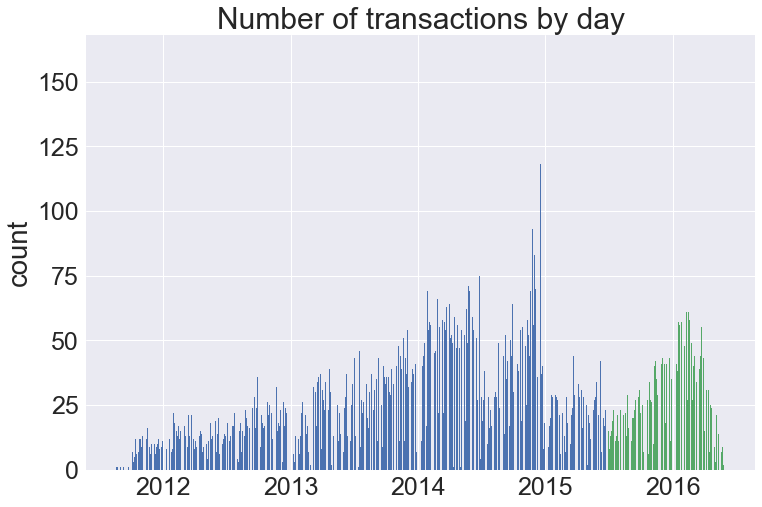

In [102]:
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
sns.set(font_scale = 2.5)
ts_vc_train = train_df['timestamp'].value_counts()
ts_vc_test = test_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 8))
plt.bar(left=ts_vc_train.index, height=ts_vc_train)
plt.bar(left=ts_vc_test.index, height=ts_vc_test)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Number of transactions by day', ylabel='count')

[<matplotlib.text.Text at 0x21c6e6a0>, <matplotlib.text.Text at 0x21fd8c50>]

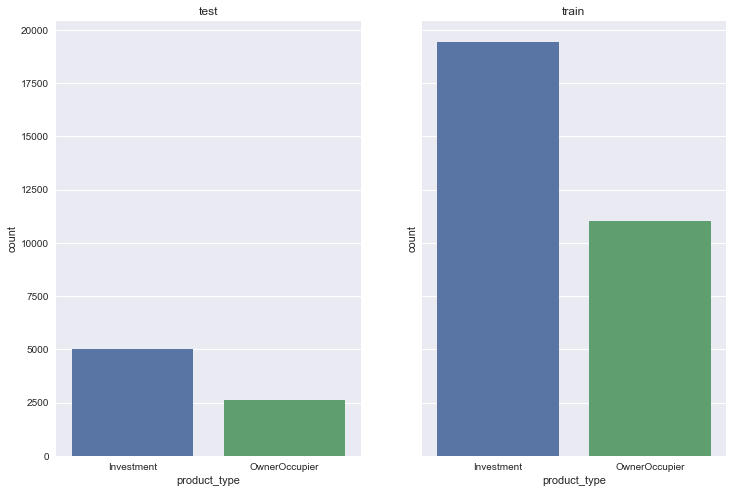

In [65]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['product_type'], ax=ax[0])
sns.countplot(x=train_df['product_type'], ax=ax[1])
ax[0].set(title='test', xlabel='product_type')
ax[1].set(title='train', xlabel='product_type')

[<matplotlib.text.Text at 0x27748f28>, <matplotlib.text.Text at 0x27798f60>]

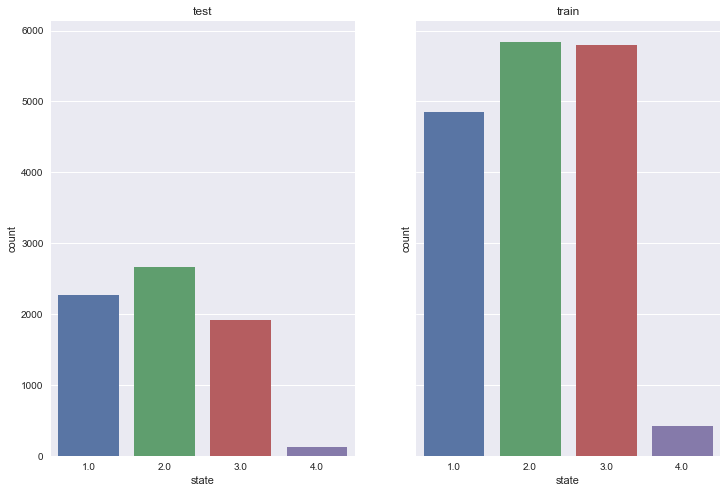

In [66]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['state'], ax=ax[0])
sns.countplot(x=train_df['state'], ax=ax[1])
ax[0].set(title='test', xlabel='state')
ax[1].set(title='train', xlabel='state')


# first big diff I see, in the test set, there
# are a lot less state 3 than in the training set

[<matplotlib.text.Text at 0x32ed2748>, <matplotlib.text.Text at 0x32ef5d30>]

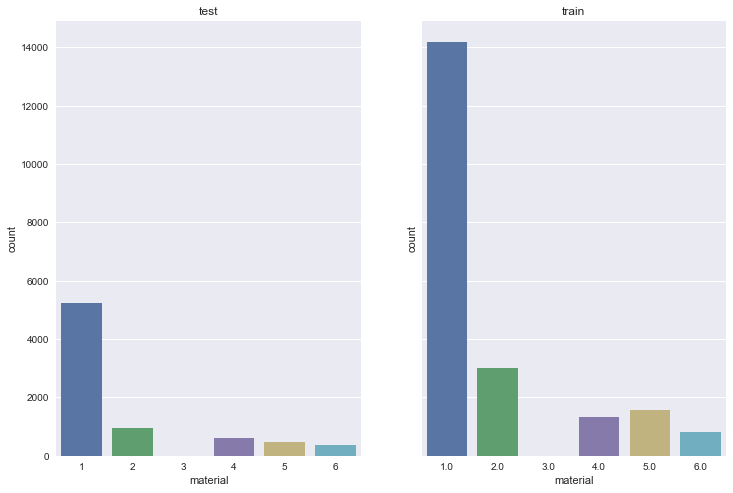

In [67]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['material'], ax=ax[0])
sns.countplot(x=train_df['material'], ax=ax[1])
ax[0].set(title='test', xlabel='material')
ax[1].set(title='train', xlabel='material')


# less of material 5

# My own stuff

In [68]:
#train_df.columns.values

In [69]:
green = ['green_part_500', 'green_part_1000','green_part_1500',
         'green_part_2000','green_part_3000','green_part_5000',
        'price_doc', 'price_doc_log', 'price_doc_log10']

prom = ['prom_part_500','prom_part_1000','prom_part_1500',
        'prom_part_2000','prom_part_3000','prom_part_5000',
       'price_doc', 'price_doc_log', 'price_doc_log10']
        
office = ['office_count_500','office_sqm_500','office_count_1000',
          'office_sqm_1000','office_count_1500', 'office_sqm_1500',
          'office_count_2000','office_sqm_2000','office_count_3000',
          'office_sqm_3000','office_count_5000','office_sqm_5000',
         'price_doc', 'price_doc_log', 'price_doc_log10']
          
# shopping malls
trc = ['trc_count_1000', 'trc_count_1500', 'trc_count_2000', 'trc_count_3000', 
       'trc_count_500', 'trc_count_5000', 'trc_sqm_1000', 'trc_sqm_1500',
       'trc_sqm_2000', 'trc_sqm_3000', 'trc_sqm_500', 'trc_sqm_5000', 'trc_count_1000', 'trc_sqm_1000',
      'price_doc', 'price_doc_log', 'price_doc_log10']
       
       
church = ['big_church_count_500', 'church_count_500', 'mosque_count_500',
         'big_church_count_1000', 'church_count_1000', 'mosque_count_1000',
         'big_church_count_1500', 'church_count_1500', 'mosque_count_1500',
         'big_church_count_3000', 'church_count_3000', 'mosque_count_3000',
         'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
         'big_church_count_2000', 'church_count_2000', 'mosque_count_2000',
         'price_doc', 'price_doc_log', 'price_doc_log10']

        
sport = ['sport_count_500','sport_count_1000','sport_count_2000', 
         'sport_count_5000','sport_count_1500','sport_count_3000',
        'price_doc', 'price_doc_log', 'price_doc_log10']

leisure = ['leisure_count_500','leisure_count_3000','leisure_count_1000',
           'leisure_count_1500','leisure_count_2000','leisure_count_5000',
          'price_doc', 'price_doc_log', 'price_doc_log10']

market = ['market_count_500','market_count_5000', 'market_count_2000',
          'market_count_1000','market_count_1500','market_count_3000',
         'price_doc', 'price_doc_log', 'price_doc_log10']    


cafe_price = ['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
              'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg','cafe_sum_1000_max_price_avg', 
              'cafe_avg_price_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 
              'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 
              'cafe_avg_price_2000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
              'cafe_avg_price_3000',  'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg',
              'cafe_avg_price_5000','cafe_count_5000_price_high', 
              'price_doc', 'price_doc_log', 'price_doc_log10']      

    
cafe_count = ['cafe_count_500', 'cafe_count_500_na_price',
       'cafe_count_500_price_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_2500',
       'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'cafe_count_1000', 
       'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
       'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500',
       'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000',
       'cafe_count_1000_price_high','cafe_count_1500',
       'cafe_count_1500_na_price',
       'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
       'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'cafe_count_2000', 
       'cafe_count_2000_na_price', 'cafe_count_2000_price_500',
       'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500',
       'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000',
       'cafe_count_2000_price_high', 'cafe_count_3000', 'cafe_count_3000_na_price',
       'cafe_count_3000_price_500', 'cafe_count_3000_price_1000',
       'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
       'cafe_count_3000_price_4000', 'cafe_count_3000_price_high','cafe_count_5000',
       'cafe_count_5000_na_price', 'cafe_count_5000_price_500',
       'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500',
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'price_doc', 'price_doc_log', 'price_doc_log10'] 
        
price = ['price_doc', 'price_doc_log', 'price_doc_log10'] 

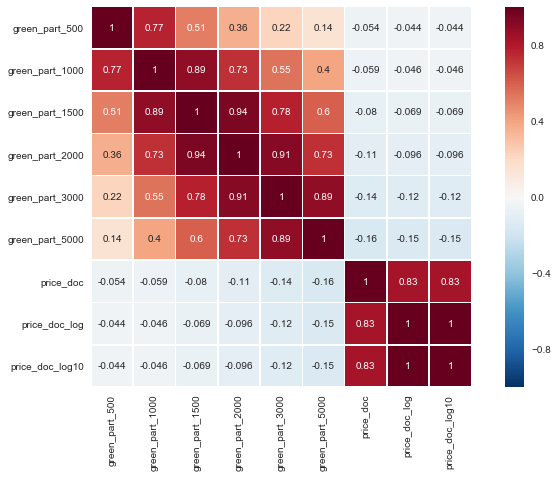

In [70]:
corrmat = train_df[green].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

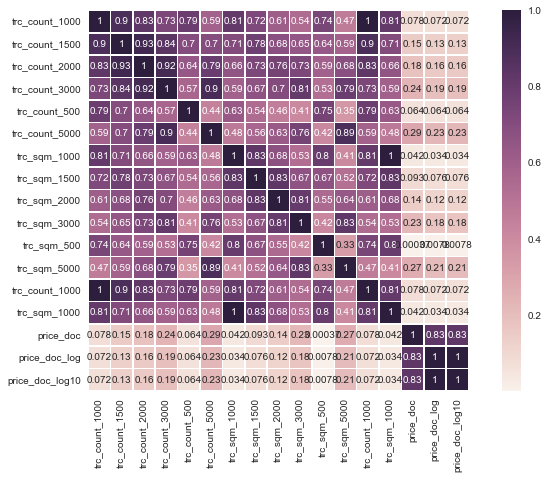

In [71]:
corrmat = train_df[trc].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

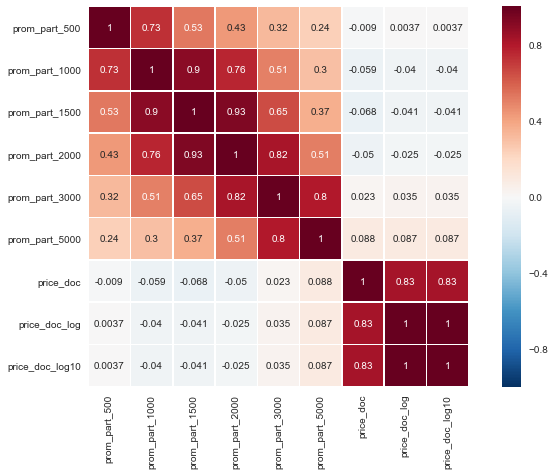

In [72]:
corrmat = train_df[prom].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

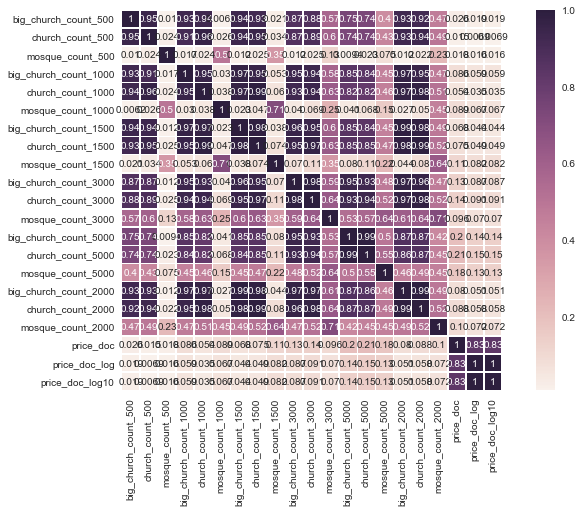

In [73]:
corrmat = train_df[church].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

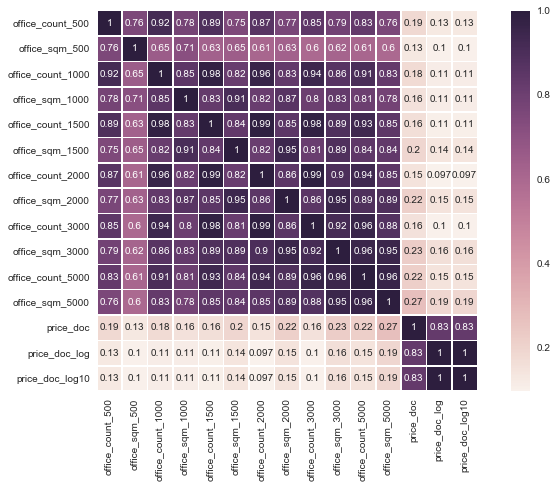

In [74]:
corrmat = train_df[office].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

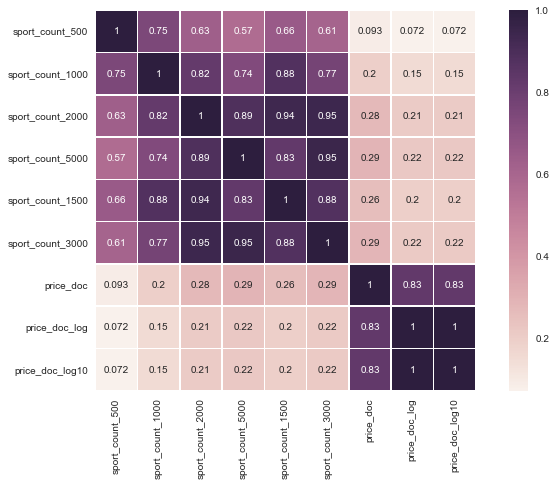

In [75]:
corrmat = train_df[sport].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

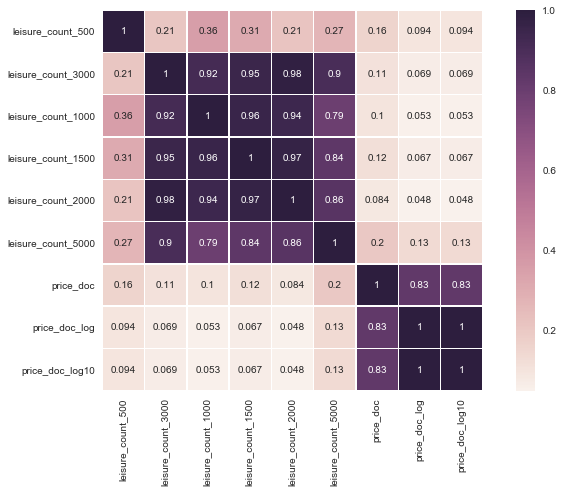

In [76]:
corrmat = train_df[leisure].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

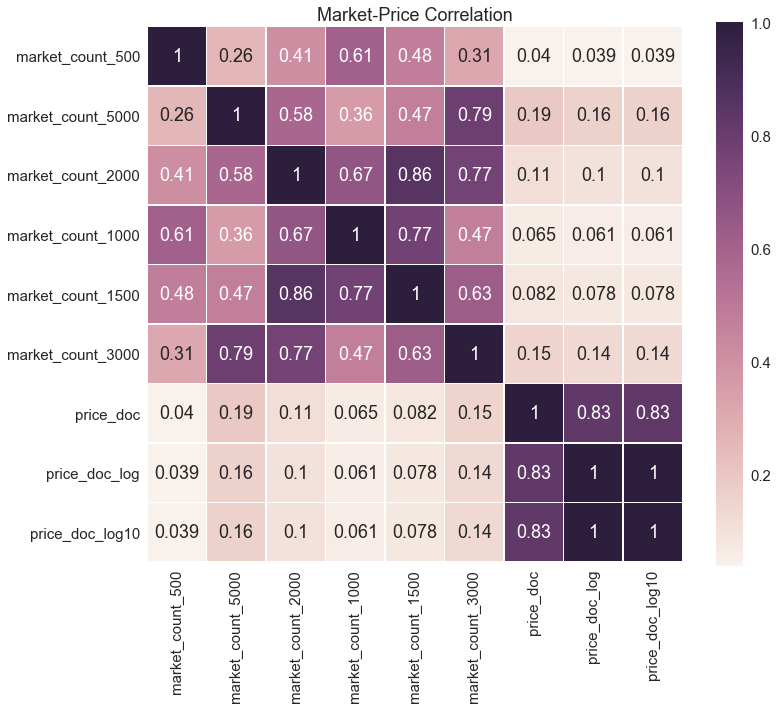

In [112]:
corrmat = train_df[market].corr()
sns.set(font_scale = 1.5)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
ax.set(title='Market-Price Correlation')

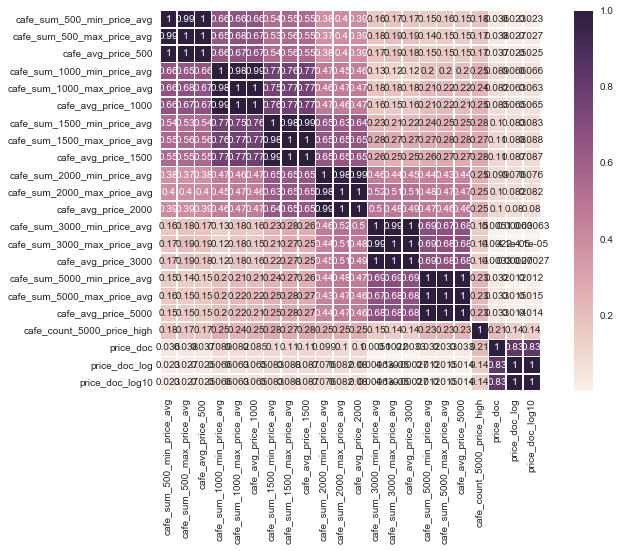

In [78]:
corrmat = train_df[cafe_price].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [79]:
important_features = ['id', 'full_sq', 'life_sq', 'floor',
                      'max_floor', 'material', 'build_year',
                      'num_room', 'kitch_sq', 'state', 'area_m',
                      'price_doc', 'gdp_quart', 'deposits_value', 
                      'deposits_growth', 'deposits_rate', 'mortgage_value',
                      'mortgage_growth', 'mortgage_rate', 'salary',
                      'unemployment', 'employment',  'oil_urals',
                      'stadium_km', 'floor', 'max_floor', 'metro_min_avto',
                      'build_year', 'cafe_count_5000_price_high', 'num_room',
                      'radiation_km',
                      'green_zone_km', 'industrial_km', 'indust_part',
                      'cpi', 'cafe_count_5000', 'cafe_count_1500_price_high',
                      'cafe_count_5000_price_500', 'cafe_count_2000_price_2500',
                      'kitch_sq', 'max_floor', 'trc_sqm_5000', 
                      'office_sqm_1000', 'trc_sqm_1500', 'office_sqm_500', 'cpi', 
                      'office_sqm_5000', 'ID_railroad_terminal', 'office_sqm_1500', 
                      'ekder_male', 'raion_popul', 'price_doc']

important_features = list(set(important_features))
# 'month', 'day',
#                       'year', 'month_year', 'week_year', 'oil_chemistry_raion_yes',

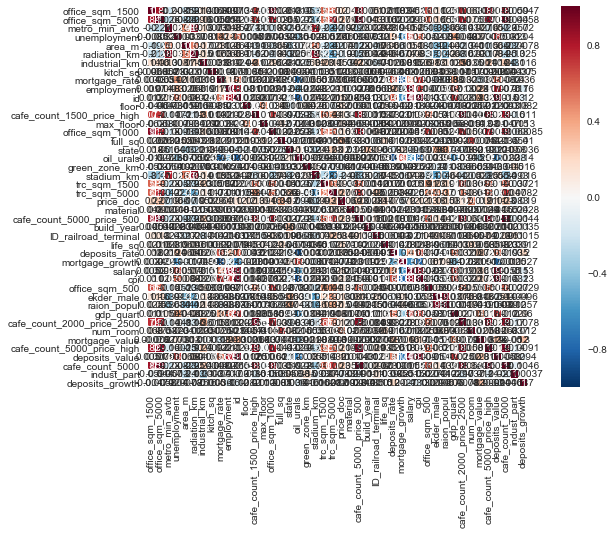

In [80]:
corrmat = train[important_features].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
# print(corrmat['price_doc'])

# 
# 
# 
# 
# 




# Linear Regression

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [82]:
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [83]:
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates = ['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates = ['timestamp'])

train['price_doc_log'] = np.log1p(train['price_doc'])
test['price_doc_log'] = np.log1p(train['price_doc'])


In [84]:
train.head(5)

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1 2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2 2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3 2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4 2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5 2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq  state product_type           sub_area        area_m  \
0       NaN       NaN    NaN   Investment           Bibirevo  6.407578e+06   
1       NaN       NaN    NaN   Investment  Nagatinskij Zaton  9.589337e+06   
2       NaN       NaN    NaN   Investment     Tekstil'shhiki  4.808270e+06   
3       NaN       NaN    NaN   Investment             Mitino  1.258354e+07   
4       NaN       NaN    NaN   Investment          Basmannoe  8.398461e+06   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572         0.189727     0.000070                9576   
1       115352         0.372602     0.049637                6880   
2       101708         0.112560     0.118537                5879   
3       178473         0.194703     0.069753               13087   
4       108171         0.015234     0.037316                5706   

   preschool_quota  preschool_education_centers_raion  children_school  \
0           5001.0                                  5            10309   
1           3119.0                                  5             7759   
2           1463.0                                  4             6207   
3           6839.0                                  9            13670   
4           3240.0                                  7             6748   

   school_quota  school_education_centers_raion  \
0       11065.0                               5   
1        6237.0                               8   
2        5580.0                               7   
3       17063.0                              10   
4        7770.0                               9   

   school_education_centers_top_20_raion  hospital_beds_raion  \
0                                      0                240.0   
1                                      0                229.0   
2                                      0               1183.0   
3                                      0                  NaN   
4                                      0                562.0   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  

In [85]:
all_data = pd.concat((train.loc))

NotImplementedError: ix is not iterable

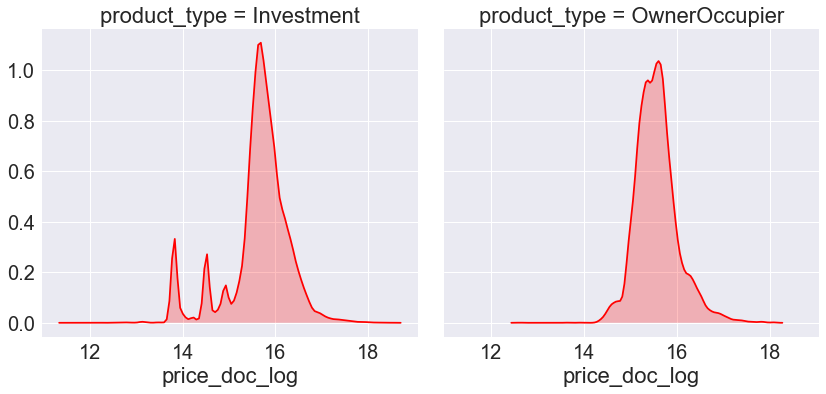

In [120]:
g = sns.FacetGrid(train_df, col = 'product_type', size = 6) # inestment vs. owner, half of  page
sns.set(font_scale = 2)
g.map(sns.kdeplot, 'price_doc_log', color = 'r', shade = True)
# g.add_legend()
ax.set(ylabel = 'density')
#spikes in random places in investment

[<matplotlib.text.Text at 0x6350f358>, <matplotlib.text.Text at 0x6354d1d0>]

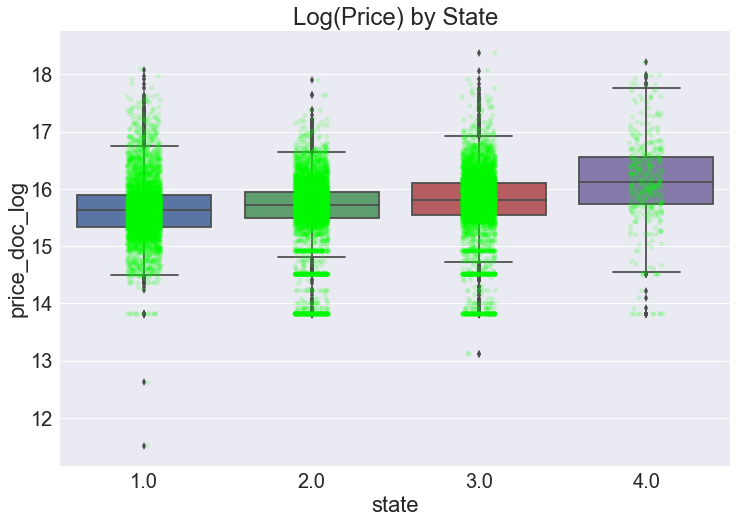

In [125]:
f, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale = 2)
ind = train_df[train_df['state'].isnull()].index
train_df['price_doc_log'] = np.log(train_df['price_doc'])
# sns.violinplot(x="state", y="price_doc_log10", 
#                data=train_df.drop(ind), inner="box")
sns.stripplot(x="state", y="price_doc_log", 
              data=train_df.drop(ind),
             jitter = True,
             alpha = 0.15,
             color = 'lime')
sns.boxplot(x="state", y="price_doc_log", 
               data=train_df.drop(ind))




ax.set(title='Log(Price) by State', 
       xlabel='state')

# 4 is the most expensive but the other three look pretty evenly distributed


# f, ax = plt.subplots(figsize=(12, 8))
# sns.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
# sns.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
# ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
#        ylabel='price_doc'